In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# **Load Dataset**

In [3]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,F,0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7038 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7040 non-null   float64
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.isna().sum()

customerID          0
gender              5
SeniorCitizen       0
Partner             0
Dependents          0
tenure              3
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
len(df)

7043

#### Insight

Terdapat beberapa missing value pada data, dan jumlahnya hanya sangat sedikit, sehingga tidak terlalu diperlukan teknik imputasi yang canggih, sehingga dalam kasus kali ini hanya menggunakan interpolasi dari pandas untuk mengisi missing valuenya

In [7]:
# fill missing value
df = df.interpolate()

# **EDA**

#### Insight

Pada bagian EDA, langkah pertama yang dilakukan adalah mencari tahu nilai unique dari setiap kolom dan tipedatanya, hal tersebut dilakukan dengan tujuan untuk melihat apa teknik encoding yang cocok untuk melakukan encode dari sebuah kolom

In [8]:
columns_info = []

for column in df.columns:
    column_name = column
    unique_values = df[column].nunique()
    dtype = df[column].dtype
    columns_info.append((column_name, unique_values, dtype))

info_cols = pd.DataFrame(columns_info, columns=['Column', 'Unique Values', 'Dtype'])
info_cols


,Column,Unique Values,Dtype
0,customerID,7043,object
1,gender,4,object
2,SeniorCitizen,2,int64
3,Partner,2,object
4,Dependents,2,object
5,tenure,80,float64
6,PhoneService,2,object
7,MultipleLines,3,object
8,InternetService,3,object
9,OnlineSecurity,3,object


#### Insight

Pada kolom total charges, terdapat data numerik yang masih bertipe object, sehingga perlu dikonversi menjadi nilai int atau float untuk dapat diproses, pada kasus kali ini, kolom total charges diubah menjadi float

In [9]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [10]:
df = df.drop(columns='customerID')

## Encoding

Teknik encoding yang digunakan ada 2, yaitu:

1. Label Encoding -> digunakan untuk kolom kategorikal ordinal, yang memiliki urutan peringkat tertentu
2. One Hot Encoding -> digunakan untuk kolom kategorikal nominal, yang tidak memiliki urutan peringkat tertentu

In [11]:
label_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'PaperlessBilling', 'Churn', 'OnlineBackup'
]

one_hot_cols = ['Contract', 'PaymentMethod']

encoding_maps = {}

df_encoded = df.copy()

for col in label_cols:
    df_encoded[col] = pd.Categorical(df_encoded[col]).codes
    encoding_maps[col] = dict(enumerate(pd.Categorical(df[col]).categories))

df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols)
df_encoded = df_encoded.astype('float64')

#### Insight

Pada proses encode, dilakukan dengan menggunakan method langsung dari pandas:
1. untuk data kategorikal ordinal
 -> Di encode dengan menggunakan .codes dari pandas
2. Untuk data kategorikal nominal
 -> Di encode dengan menggunakan .categories dari pandas

Hasil dari encoding juga disimpan pada dataframe encoding maps, sehingga representasi dari encode dapat tetap dilihat dan diinterpretasikan 

In [12]:
encoding_maps

{'gender': {0: 'F', 1: 'Female', 2: 'M', 3: 'Male'},
 'Partner': {0: 'No', 1: 'Yes'},
 'Dependents': {0: 'No', 1: 'Yes'},
 'PhoneService': {0: 'No', 1: 'Yes'},
 'MultipleLines': {0: 'No', 1: 'No phone service', 2: 'Yes'},
 'InternetService': {0: 'DSL', 1: 'Fiber optic', 2: 'No'},
 'OnlineSecurity': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'DeviceProtection': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'TechSupport': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'StreamingTV': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'StreamingMovies': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'PaperlessBilling': {0: 'No', 1: 'Yes'},
 'Churn': {0: 'No', 1: 'Yes'},
 'OnlineBackup': {0: 'No', 1: 'No internet service', 2: 'Yes'}}

In [63]:
df_encoded['TotalCharges_log'] = np.log1p(df_encoded['TotalCharges'])

In [65]:
df_encoded['MonthlyCharges_log'] = np.log1p(df_encoded['MonthlyCharges'])

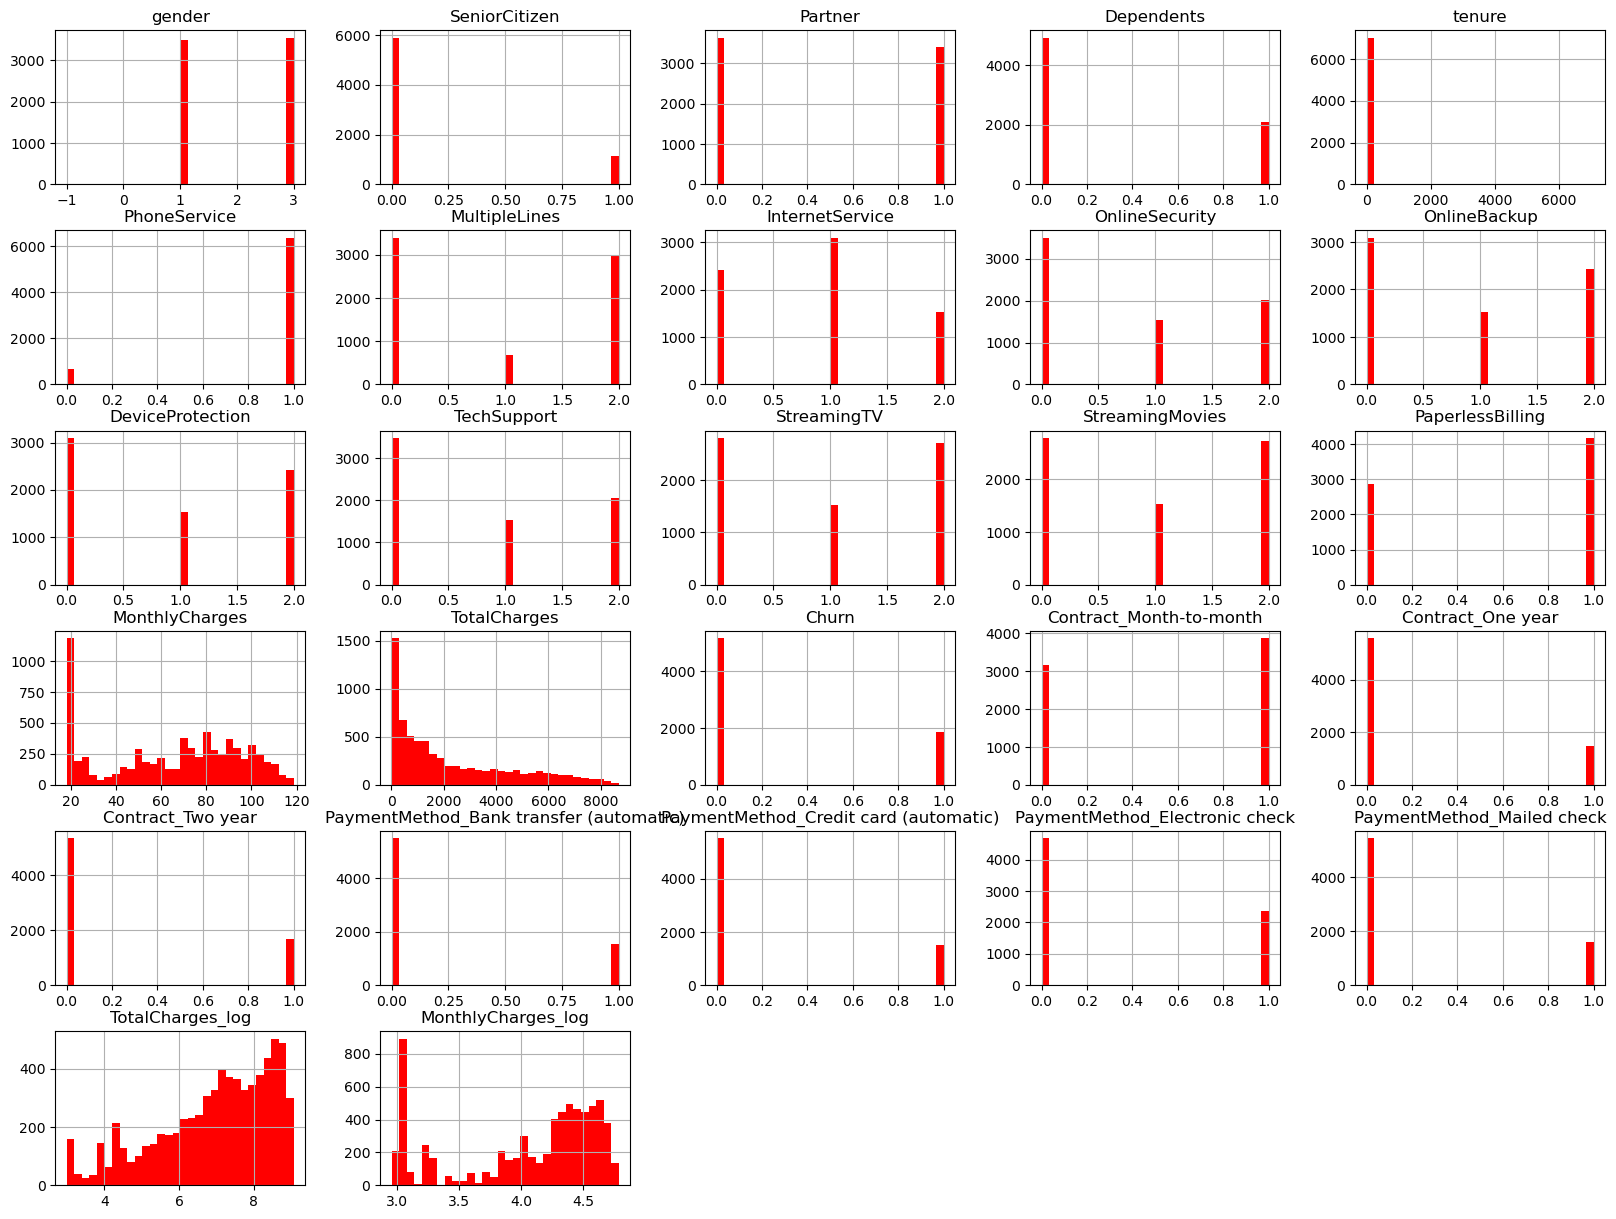

In [66]:
df_encoded.hist(bins = 30, figsize=(20, 15), color = 'red');

#### Insight

Setelah dilakukan plot histogram dari setiap kolom yang ada pada data, diketahui bahwa 23 dari 25 kolom memiliki nilai kategorikal, dan untuk nilai numerikal distribusinya tidak normal melainkan miring ke kanan, sehingga perlu dilakukan transformasi, teknik transformasi yang digunakan adalah logaritmik

In [14]:
pd.DataFrame(df_encoded.describe()).T

,count,mean,std,min,25%,50%,75%,max
gender,7043.0,2.006815,1.003096,-1.00,1.00,3.000,3.0000,3.00
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
Partner,7043.0,0.483033,0.499748,0.00,0.00,0.000,1.0000,1.00
Dependents,7043.0,0.299588,0.458110,0.00,0.00,0.000,1.0000,1.00
tenure,7043.0,35.034928,115.259247,0.00,9.00,29.000,55.0000,7100.00
PhoneService,7043.0,0.903166,0.295752,0.00,1.00,1.000,1.0000,1.00
MultipleLines,7043.0,0.940508,0.948554,0.00,0.00,1.000,2.0000,2.00
InternetService,7043.0,0.872923,0.737796,0.00,0.00,1.000,1.0000,2.00
OnlineSecurity,7043.0,0.790004,0.859848,0.00,0.00,1.000,2.0000,2.00
OnlineBackup,7043.0,0.906432,0.880162,0.00,0.00,1.000,2.0000,2.00


### Data Splitting

In [68]:
# declare features and target
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

In [69]:
# lihat jumlah data
print(f'Count of X: {X.shape}\ncount of y: {y.shape}')

Count of X: (7043, 26)
count of y: (7043,)


In [70]:
c0 = df_encoded[df_encoded.Churn==0]
c1 = df_encoded[df_encoded.Churn==1]
print(f'count of data with label 0: {len(c0)}\ncount of data with label 1: {len(c1)}')

count of data with label 0: 5174
count of data with label 1: 1869


In [132]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7043 non-null   float64
 1   SeniorCitizen                            7043 non-null   float64
 2   Partner                                  7043 non-null   float64
 3   Dependents                               7043 non-null   float64
 4   tenure                                   7043 non-null   float64
 5   PhoneService                             7043 non-null   float64
 6   MultipleLines                            7043 non-null   float64
 7   InternetService                          7043 non-null   float64
 8   OnlineSecurity                           7043 non-null   float64
 9   OnlineBackup                             7043 non-null   float64
 10  DeviceProtection                         7043 no

<Axes: xlabel='Churn', ylabel='count'>

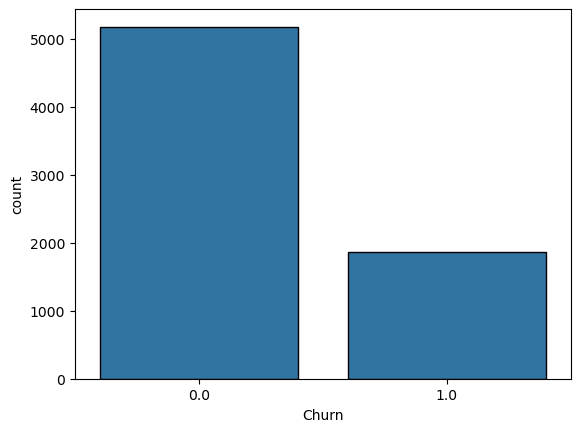

In [71]:
# see proportion of labels
sns.countplot(x='Churn', data=df_encoded, edgecolor='black')

### Insight

Setelah dihitung dan dilakukan countplot untuk data y (Customer Churn), diketahui bahwa nilai dari label terindikasi imbalance, dengan proporsi 5174 record merupakan pelanggan tidak Churn dan 1869 record merupakan pelanggan Churn

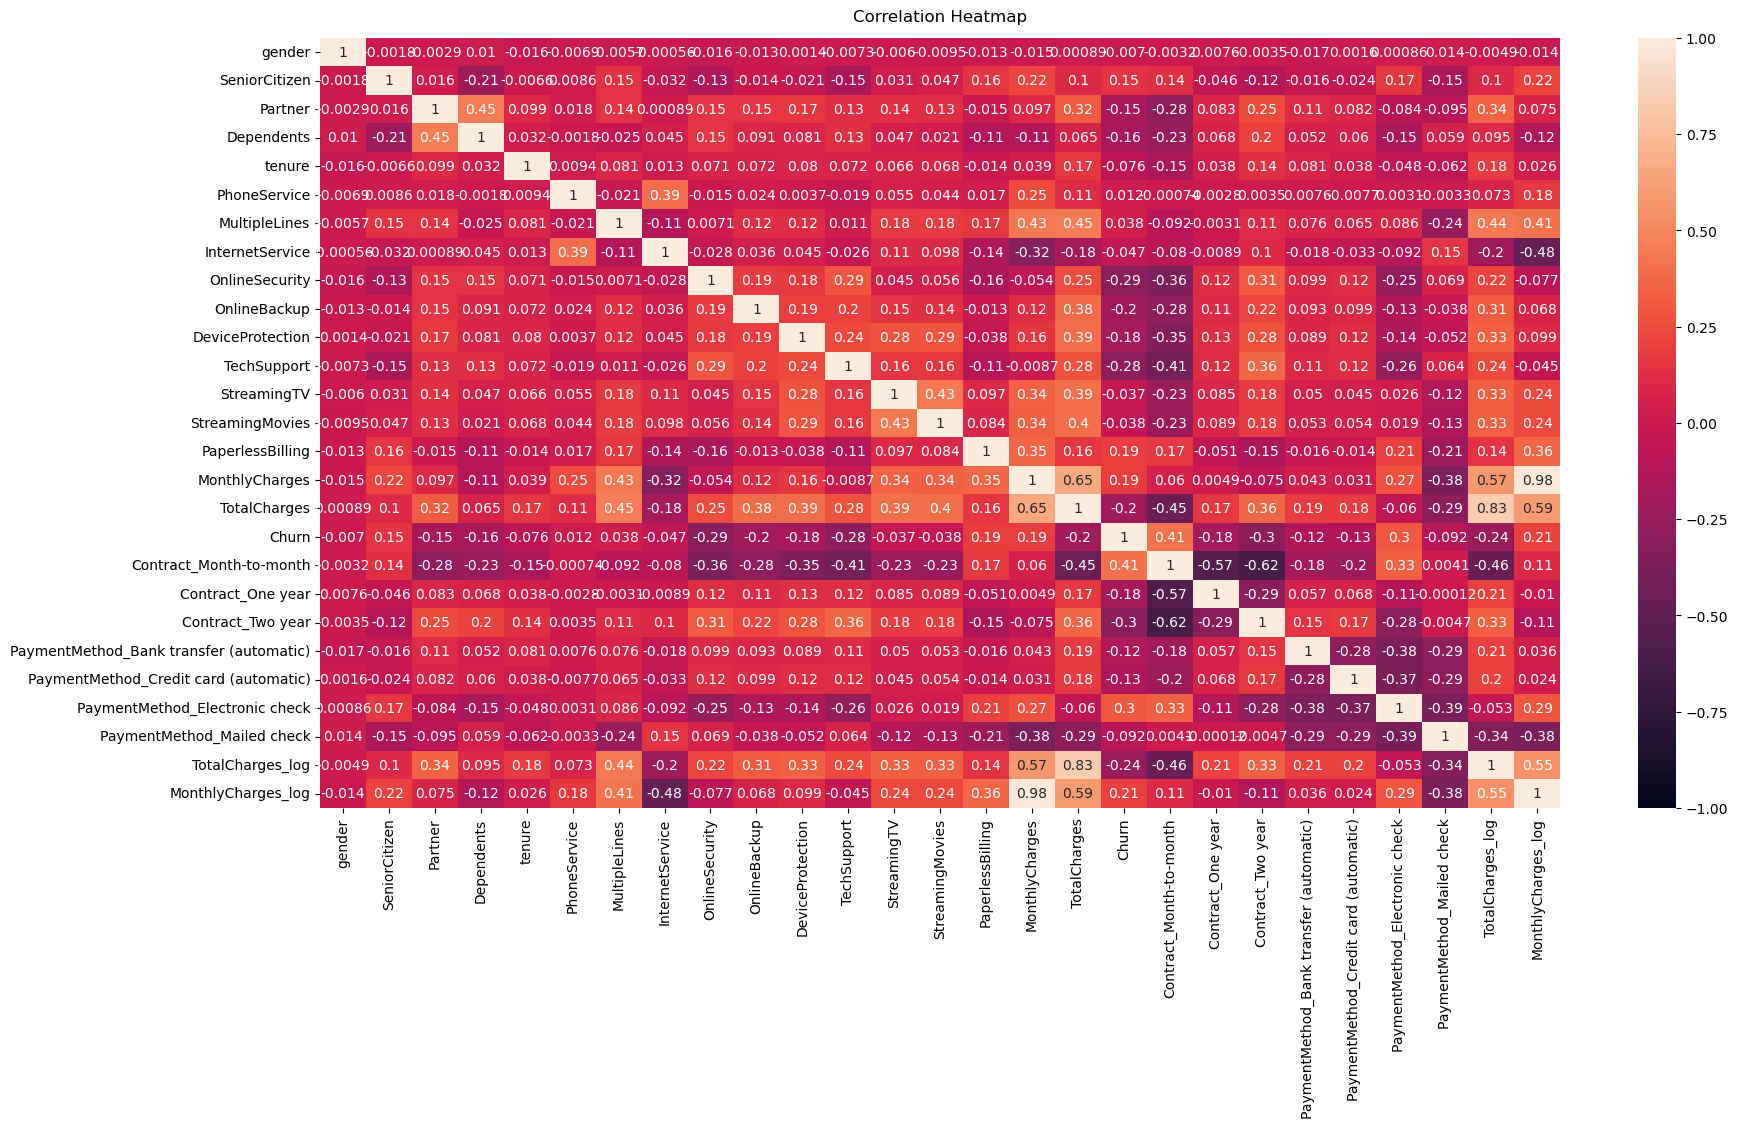

In [72]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(df_encoded.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Insight

Dari cek hasil korelasi juga menyatakan bahwa korelasi antar setiap fitur dengan targetnya tergolong lemah. Namun untuk salah satu fitur hasil encoding one hot dari Contract, yaitu 'Contract_Month-to-month' dan 'PaymentMethod_Electronic check' dari Payment Method , memiliki korelasi yang sedang dengan customer churn, hal tersebut menandakan bahwa nilai boolean pada kontrak bulan per bulan yang diperpanjang "cukup mempengaruhi" nilai customer churn 

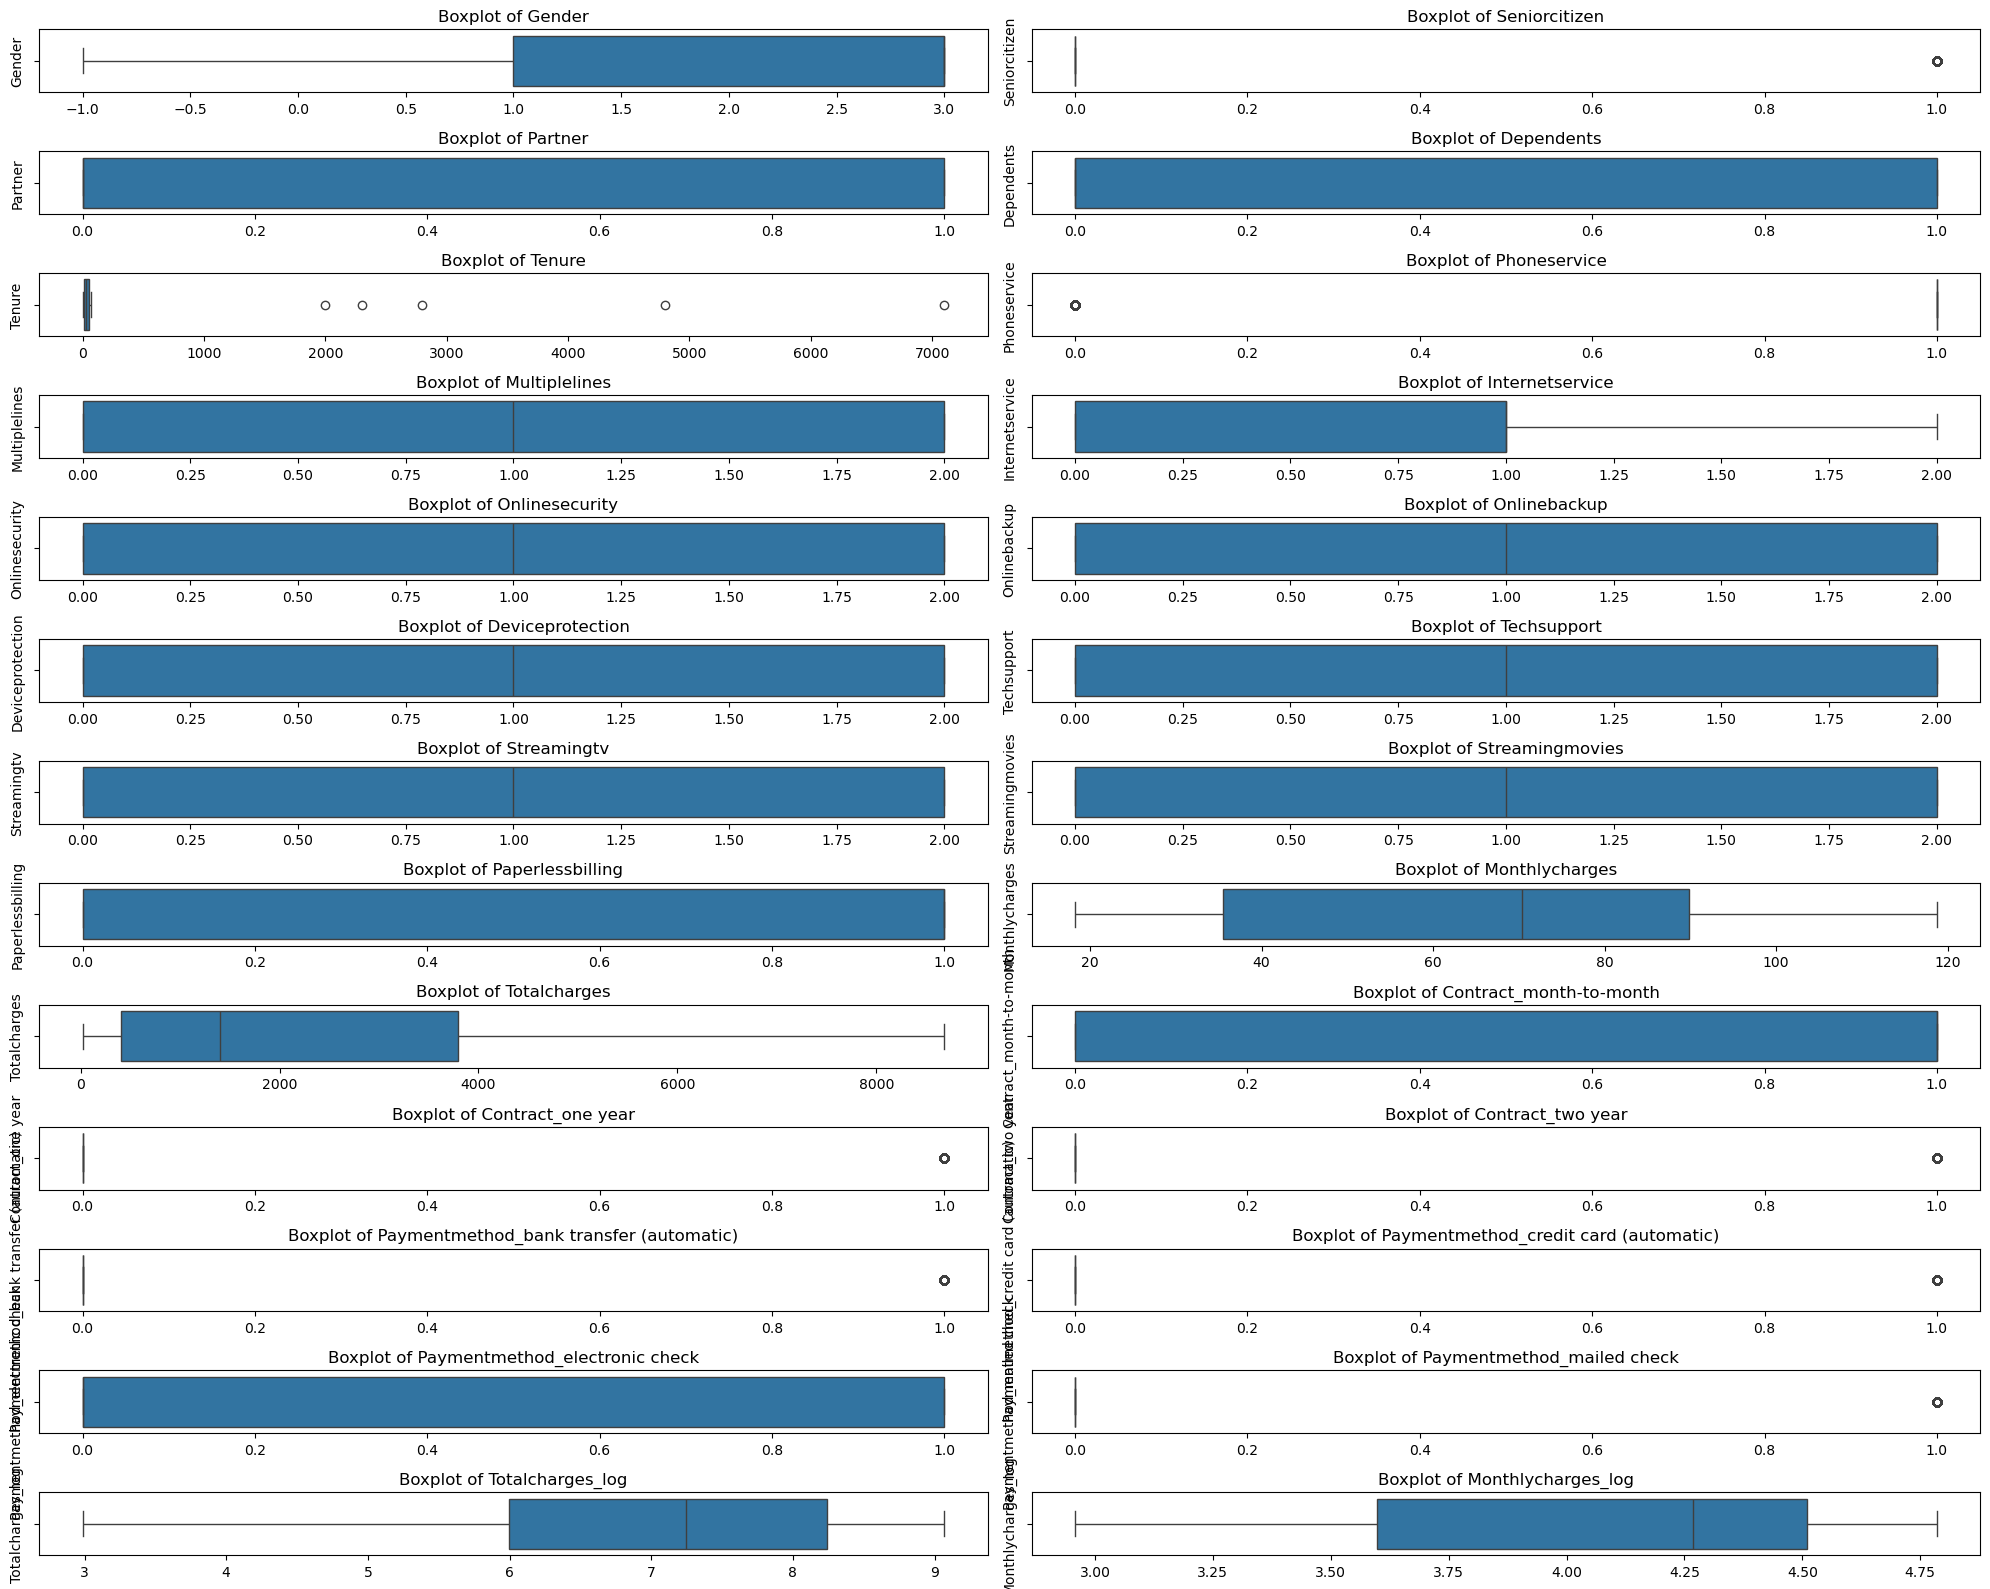

In [73]:
# check outlier

num_features = len(X.columns)
num_rows = (num_features - 1) // 2 + 1
num_cols = min(num_features, 2)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 16))
axes = axes.flatten()
for i, feature in enumerate(X.columns):
    ax = axes[i]
    
    sns.boxplot(data=X, x=feature, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feature.capitalize())
    ax.set_title(f'Boxplot of {feature.capitalize()}')

for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axes[j])

fig.tight_layout()

plt.show()

#### Insight

Setelah dilakukan cek outlier dengan menggunakan boxplot, juga terlihat data memiliki beberapa outlier khususnya pada kolom numeriknya 'MonthlyCharges' dan 'TotalCharges'

### Blind test dengan default data

Pada percobaan awal ini, dilakukan fitting data sebelum dilakukan preprocessing dengan menggunakan decision tree, hal ini dilakukan dengan sebagai langkah awal dan untuk perbandingan hasil yang telah dilakukan improve dari data dan juga model

In [74]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=11)

In [75]:
# declare model dtc
dtc = DTC(random_state=11,
          criterion='entropy')

In [76]:
# fitting the train data into model
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=11)

In [77]:
# do a prediction using test data
npr_pred = dtc.predict(X_test)
acc_dtc = accuracy_score(y_test, npr_pred)
acc_dtc

0.7864849517319704

In [78]:
# make a classification report
print(classification_report(y_test, npr_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86      1276
         1.0       0.63      0.56      0.59       485

    accuracy                           0.79      1761
   macro avg       0.73      0.72      0.72      1761
weighted avg       0.78      0.79      0.78      1761



#### Insight

Dengan menggunakan decision tree dengan data yang telah di encoding, didapatkan hasil 0.778, yang menunjukkan bahwa model masih belum baik untuk mengklasifikasikan fitur dengan target

# **Preprocess Data**

#### Insight

Dari hasil boxplot dan histplot, diketahui bahwa terdapat beberapa outlier pada data, pada langkah awal preprocessing, akan di hapus outlier dengan menggunakan metode iqr (interquartile)

In [79]:
# drop outlier

import pandas as pd
import numpy as np

def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

numeric_columns = ['MonthlyCharges', 'TotalCharges']

df_no_outliers = remove_outliers_iqr(df_encoded, numeric_columns)

print(f"Jumlah baris sebelum menghapus outlier: {len(df_encoded)}")
print(f"Jumlah baris setelah menghapus outlier: {len(df_no_outliers)}")
print(f"Jumlah baris yang dihapus: {len(df_encoded) - len(df_no_outliers)}")

Jumlah baris sebelum menghapus outlier: 7043
Jumlah baris setelah menghapus outlier: 7032
Jumlah baris yang dihapus: 11


In [80]:
# rows_to_drop = df_no_outliers[df_no_outliers['Churn'] == 0].head(3305)
# df_no_outliers_dropped = df_no_outliers.drop(rows_to_drop.index)

In [81]:
# declare features and target
X = df_no_outliers.drop(columns='Churn')
y = df_no_outliers['Churn']

In [82]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=11)

In [83]:
# do normalization

ss = StandardScaler() # Standardization
mms = MinMaxScaler() # MinMaxScaler

In [84]:
cols_to_normalize = ['MonthlyCharges', 'TotalCharges']

ss = StandardScaler()
mms = MinMaxScaler()

def normalize_columns(df, columns, scaler):
    df_normalized = df.copy()
    df_normalized[columns] = scaler.fit_transform(df[columns])
    return df_normalized

ss_X_train = normalize_columns(X_train, cols_to_normalize, ss)
ss_X_test = normalize_columns(X_test, cols_to_normalize, ss)

mms_X_train = normalize_columns(X_train, cols_to_normalize, mms)
mms_X_test = normalize_columns(X_test, cols_to_normalize, mms)

In [85]:
# fitting the train data into model
dtc.fit(ss_X_train, y_train)

# do a prediction using test data
npr_pred1=dtc.predict(ss_X_test)
acc_ss_dtc = accuracy_score(y_test, npr_pred1)
print(f'accuration of Standarized Decision Tree : {acc_ss_dtc}')

# fitting the train data into model
dtc.fit(mms_X_train, y_train)

# do a prediction using test data
npr_pred2=dtc.predict(mms_X_test)
acc_mms_dtc = accuracy_score(y_test, npr_pred2)
print(f'accuration of MinMaxScaled Decision Tree : {acc_mms_dtc}')

accuration of Standarized Decision Tree : 0.7201365187713311
accuration of MinMaxScaled Decision Tree : 0.7258248009101251


#### Insight
Normalisasi data dengan menggunakan min max scaler maupun standard scaler tidak dapat meningkatkan akurasi dari model, percobaan juga telah dilakukan dengan menggunakan model lainnya, hasilnya dari normalisasi tidak menunjukkan peningkatan yang signifikan. Sehingga pada kasus kali ini tidak akan melakukan proses normalisasi.

## Mencari Fitur yang Penting

Untuk mencari importance features, pada kasus kali ini menggunakan MI (Mutual Information), Chi Square, dan Features Importance menggunakan Random Forest

1. Mutual Information
 - Mutual Information adalah ukuran statistik yang mengukur ketergantungan antara dua variabel. Pada machine learning, Mutual Information digunakan untuk menentukan seberapa besar informasi yang dibagikan antara fitur dan target variabel.
2. Chi Square
 - Chi-Square adalah tes statistik yang digunakan untuk menentukan apakah ada hubungan yang signifikan antara dua variabel categorical. Dalam features selection pada kasus ini, Chi-Square digunakan untuk mengevaluasi ketergantungan antara fitur categorical dan target variabel categorical.
3. Feature Importance
 - Feature Importance dapat mengukur kontribusi relatif dari setiap fitur dalam membuat prediksi yang akurat, pada kasus kali ini menggunakan Random Forest.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

def mutual_info_analysis(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    mi_scores.plot.bar()
    plt.title('Mutual Information Scores')
    plt.xlabel('Features')
    plt.ylabel('Mutual Information')
    plt.tight_layout()
    plt.show()
    
    return mi_scores

def chi_square_analysis(X, y):
    X_encoded = X.apply(LabelEncoder().fit_transform)
    chi2_scores, _ = chi2(X_encoded, y)
    chi2_scores = pd.Series(chi2_scores, name="Chi-Square Scores", index=X.columns)
    chi2_scores = chi2_scores.sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    chi2_scores.plot.bar()
    plt.title('Chi-Square Test Scores')
    plt.xlabel('Features')
    plt.ylabel('Chi-Square Score')
    plt.tight_layout()
    plt.show()
    
    return chi2_scores

def rf_feature_importance(X, y):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    importances.plot.bar()
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return importances


Mutual Information Analysis:


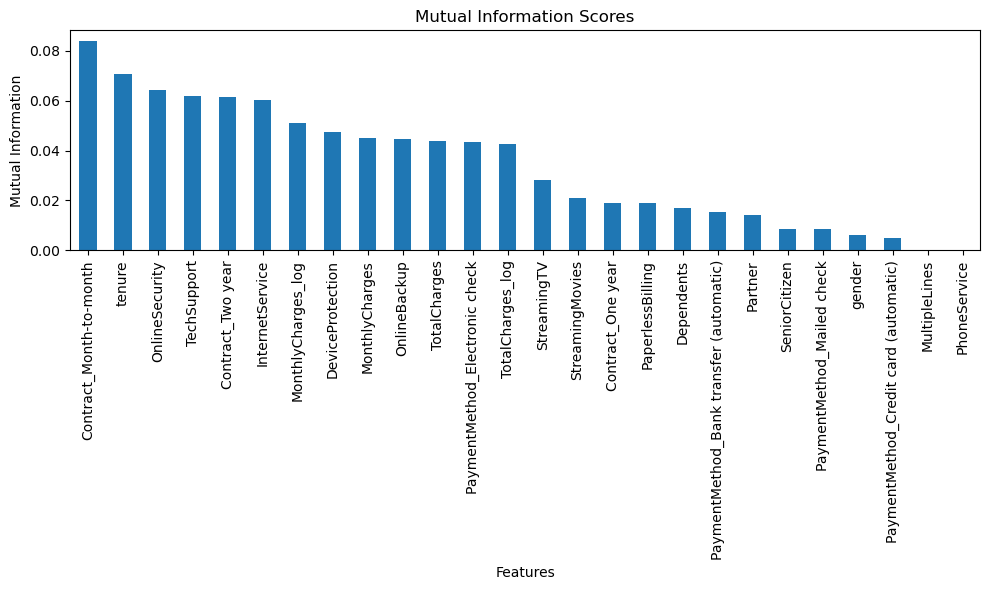

Contract_Month-to-month                    0.083997
tenure                                     0.070582
OnlineSecurity                             0.064107
TechSupport                                0.061890
Contract_Two year                          0.061325
InternetService                            0.060406
MonthlyCharges_log                         0.051216
DeviceProtection                           0.047613
MonthlyCharges                             0.045167
OnlineBackup                               0.044673
TotalCharges                               0.043898
PaymentMethod_Electronic check             0.043551
TotalCharges_log                           0.042684
StreamingTV                                0.028110
StreamingMovies                            0.021154
Contract_One year                          0.018963
PaperlessBilling                           0.018848
Dependents                                 0.017071
PaymentMethod_Bank transfer (automatic)    0.015508
Partner     

In [87]:
print("\nMutual Information Analysis:")
mi_scores = mutual_info_analysis(X, y)
print(mi_scores)

### Insight

Dapat dilihat pada grafik dan juga nilai MI dari setiap fitur, fitur Contract_Month-to-month memiliki nilai tertinggi, yang mana semakin tinggi nilai MI Score, maka semakin saling bergantung X dengan y


Chi-Square Test Analysis:


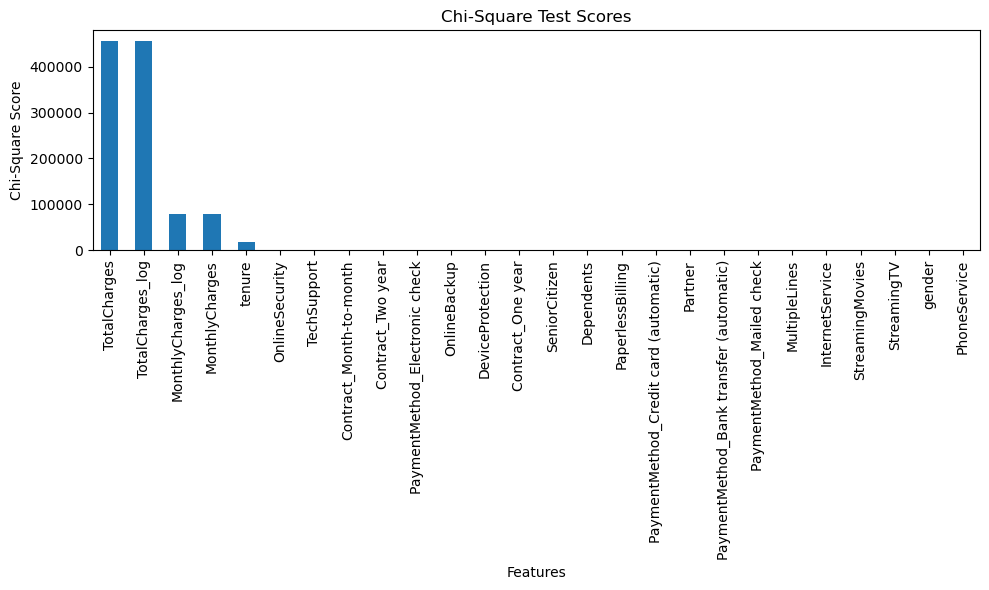

TotalCharges                               456026.758303
TotalCharges_log                           456026.758303
MonthlyCharges_log                          78740.526254
MonthlyCharges                              78740.526254
tenure                                      17371.373696
OnlineSecurity                                550.437364
TechSupport                                   522.164716
Contract_Month-to-month                       516.714004
Contract_Two year                             486.223101
PaymentMethod_Electronic check                424.113152
OnlineBackup                                  229.441123
DeviceProtection                              190.688004
Contract_One year                             176.608724
SeniorCitizen                                 133.482766
Dependents                                    131.271509
PaperlessBilling                              104.979224
PaymentMethod_Credit card (automatic)          99.972539
Partner                        

In [88]:
print("\nChi-Square Test Analysis:")
chi2_scores = chi_square_analysis(X, y)
print(chi2_scores)

#### Insight

Dilihat dari hasil dari nilai chi-square dari variabel X, terlihat sangat jomplang, hal tersebut menandakan bahwa beberapa fitur memiliki hubungan yang sangat kuat dengan target, sementara itu fitur lainnya tidak memiliki hubungan yang signifikan


Random Forest Feature Importance:


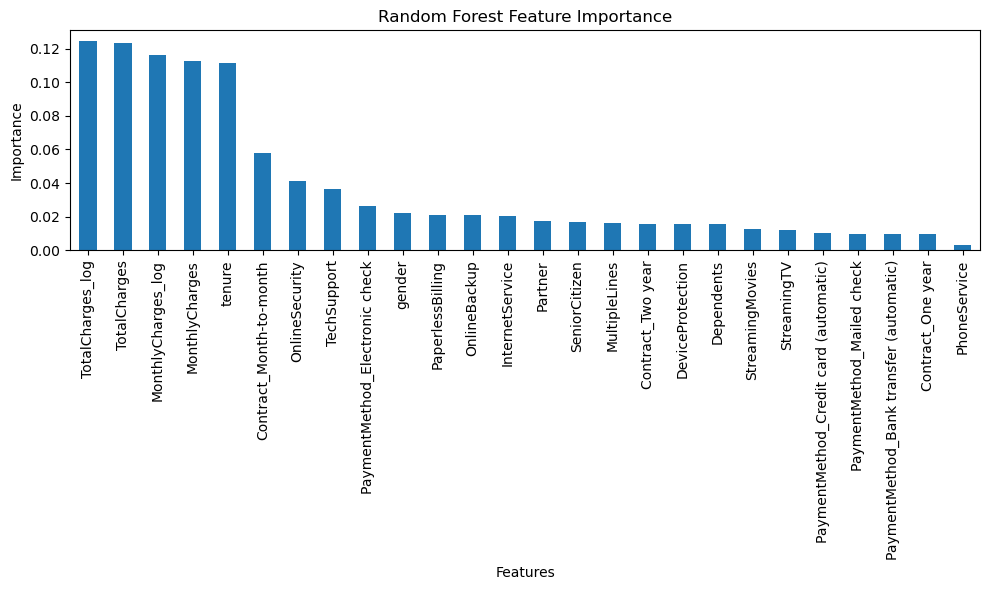

TotalCharges_log                           0.124599
TotalCharges                               0.123024
MonthlyCharges_log                         0.116344
MonthlyCharges                             0.112680
tenure                                     0.111281
Contract_Month-to-month                    0.057694
OnlineSecurity                             0.041530
TechSupport                                0.036754
PaymentMethod_Electronic check             0.026480
gender                                     0.021989
PaperlessBilling                           0.021133
OnlineBackup                               0.021102
InternetService                            0.020428
Partner                                    0.017446
SeniorCitizen                              0.016817
MultipleLines                              0.016540
Contract_Two year                          0.015862
DeviceProtection                           0.015792
Dependents                                 0.015438
StreamingMov

In [89]:
print("\nRandom Forest Feature Importance:")
rf_importance = rf_feature_importance(X, y)
print(rf_importance)

#### Insight

dari hasil uji random forest features importance, Total Charges, Monthly Charges, tenure adalah fitur yang paling penting menurut model Random Forest. Ini berarti bahwa informasi yang diberikan oleh fitur ini sangat signifikan dalam membuat prediksi. Sedangkan sebaliknya Phone Service, Contract one year merupakan fitur yang lemah dan tidak terlalu berpengaruh terhadap hasil prediksi

In [90]:
feature_scores = pd.DataFrame({
    'MI Scores': mi_scores,
    'Chi-Square Scores': chi2_scores,
    'RF Importances': rf_importance
})

feature_scores = (feature_scores - feature_scores.min()) / (feature_scores.max() - feature_scores.min())
feature_scores['Mean Score'] = feature_scores.mean(axis=1)
selected_features = feature_scores.sort_values(by='Mean Score', ascending=False).index

In [91]:
feature_scores.sort_values(by='Mean Score', ascending=False)

,MI Scores,Chi-Square Scores,RF Importances,Mean Score
TotalCharges,0.522617,1.000000e+00,0.987012,0.836543
TotalCharges_log,0.508160,1.000000e+00,1.000000,0.836053
tenure,0.840292,3.809269e-02,0.890183,0.589523
MonthlyCharges_log,0.609738,1.726663e-01,0.931926,0.571443
MonthlyCharges,0.537717,1.726663e-01,0.901719,0.537367
Contract_Month-to-month,1.000000,1.132875e-03,0.448302,0.483145
OnlineSecurity,0.763208,1.206825e-03,0.315012,0.359809
TechSupport,0.736812,1.144827e-03,0.275631,0.337863
InternetService,0.719149,2.110035e-05,0.141003,0.286725
Contract_Two year,0.730089,1.066013e-03,0.103349,0.278168


#### Insight
Berikan Threshold Untuk 0.2 untuk Mean Score, threshold digunakan sebagai ambang batas pengambilan fitur, dengan menggunakan fitur yang memiliki mean score > 0.2, maka fitur fitur tersebut merupakan fitur yang memiliiki pengaruh lebih tinggi dibandingkan fitur lainnya

angka 0.2 dipilih karena sebagai angka optimal (penengah) dari seluruh nilai mean score dari fitur, percobaan penaikan threshold juga sempat dilakukan di angka 0.5, namun karena fitur yang terseleksi sedikit, hasil dari akurasi model juga menurun. Karena itu nilai 0.2 kembali dipilih menjadi nilai threshold

In [92]:
feature_scores[feature_scores['Mean Score'] > 0.2]

,MI Scores,Chi-Square Scores,RF Importances,Mean Score
Contract_Month-to-month,1.000000,0.001133,0.448302,0.483145
Contract_Two year,0.730089,0.001066,0.103349,0.278168
DeviceProtection,0.566849,0.000418,0.102773,0.223347
InternetService,0.719149,0.000021,0.141003,0.286725
MonthlyCharges,0.537717,0.172666,0.901719,0.537367
MonthlyCharges_log,0.609738,0.172666,0.931926,0.571443
OnlineBackup,0.531840,0.000503,0.146564,0.226302
OnlineSecurity,0.763208,0.001207,0.315012,0.359809
PaymentMethod_Electronic check,0.518481,0.000930,0.190906,0.236772
TechSupport,0.736812,0.001145,0.275631,0.337863


In [94]:
cols = ['Contract_Month-to-month', 'Contract_Two year', 'InternetService', 'MonthlyCharges_log', 'OnlineBackup', 'OnlineSecurity', 'PaymentMethod_Electronic check', 'TechSupport', 'TotalCharges', 'tenure']
# cols = ['Contract_Month-to-month', 'MonthlyCharges', 'TotalCharges', 'tenure']

In [134]:
df_encoded["Churn"]

0       0.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
7038    0.0
7039    0.0
7040    0.0
7041    1.0
7042    0.0
Name: Churn, Length: 7043, dtype: float64

In [95]:
# ambil fitur yang mean score > threshold
X = X[cols]
X.head()

,Contract_Month-to-month,Contract_Two year,InternetService,MonthlyCharges_log,OnlineBackup,OnlineSecurity,PaymentMethod_Electronic check,TechSupport,TotalCharges,tenure
0,1.0,0.0,0.0,3.429137,2.0,0.0,1.0,0.0,29.85,1.0
1,0.0,0.0,0.0,4.059581,0.0,2.0,0.0,0.0,1889.50,34.0
2,1.0,0.0,0.0,4.004602,2.0,2.0,0.0,0.0,108.15,2.0
3,0.0,0.0,0.0,3.768153,0.0,2.0,0.0,2.0,1840.75,45.0
4,1.0,0.0,1.0,4.272491,0.0,0.0,1.0,0.0,151.65,2.0


### Resampling SMOTE

In [96]:
# Karena data y juga terindikasi imbalance, disini akan dilakukan 2 treatment untuk mengatasinya, yaitu oversampling dan undersampling

# oversampling
# using imblearn to stratified label
smote = SMOTE(random_state=42)
X_ovs, y_ovs = smote.fit_resample(X, y)

<Axes: xlabel='Churn', ylabel='count'>

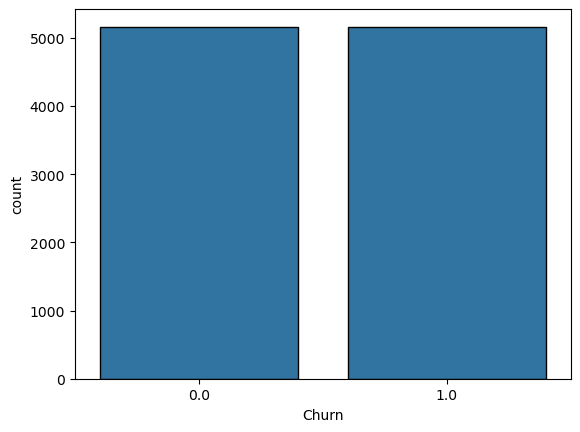

In [97]:
# plot y after oversampling
sns.countplot(x='Churn', data=pd.DataFrame(y_ovs), edgecolor='black')

In [98]:
# lakukkan kembali splitting dari data yang telah di resample
X_train_ovs, X_test_ovs, y_train_ovs, y_test_ovs = train_test_split(X_ovs, 
                                                    y_ovs, 
                                                    test_size=0.25, 
                                                    random_state=11)

In [99]:
# do a prediction and check accuracy score
dtc.fit(X_train_ovs, y_train_ovs)
pr_pred_ovs=dtc.predict(X_test_ovs)
acc_ovsbcl = accuracy_score(y_test_ovs, pr_pred_ovs)
acc_ovsbcl

0.814872192099148

In [100]:
print(f"{X_train_ovs.shape}, {y_train_ovs.shape}")

(7744, 10), (7744,)


### Resampling SMOTEENN

In [101]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X, y)

<Axes: xlabel='Churn', ylabel='count'>

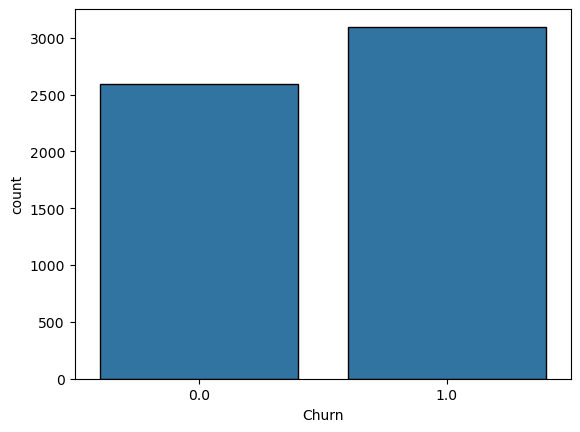

In [102]:
# plot y after smoteenn
sns.countplot(x='Churn', data=pd.DataFrame(y_smoteenn), edgecolor='black')

In [103]:
# lakukkan kembali splitting dari data yang telah di resample
X_train_smoteenn, X_test_smoteenn, y_train_smoteenn, y_test_smoteenn = train_test_split(X_smoteenn, 
                                                    y_smoteenn, 
                                                    test_size=0.25, 
                                                    random_state=11)

In [104]:
# do a prediction and check accuracy score
dtc.fit(X_train_smoteenn, y_train_smoteenn)
pr_pred_smoteenn=dtc.predict(X_test_smoteenn)
acc_smoteenn_bcl = accuracy_score(y_test_smoteenn, pr_pred_smoteenn)
acc_smoteenn_bcl

0.9501054111033029

In [105]:
print(classification_report(y_test_smoteenn, pr_pred_smoteenn))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       667
         1.0       0.95      0.96      0.95       756

    accuracy                           0.95      1423
   macro avg       0.95      0.95      0.95      1423
weighted avg       0.95      0.95      0.95      1423



### Undersampling

In [106]:
from imblearn.under_sampling import ClusterCentroids

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [108]:
cluster_centroids = ClusterCentroids(random_state=42)
X_resampled, y_resampled = cluster_centroids.fit_resample(X_train, y_train)

In [109]:
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83      1549
         1.0       0.55      0.79      0.65       561

    accuracy                           0.78      2110
   macro avg       0.73      0.78      0.74      2110
weighted avg       0.82      0.78      0.79      2110



### Catboost Classifier

#### Insight

Penggunaan Random Search
Random Search digunakan karena merupakan algoritma tuning yang cepat jika dibandingkan grid search. Karena random search mencoba secara acak dari distribusi yang ditentukan dari hyperparameter, dibandingkan dengan grid search yang mencoba semua kombinasi dari hyperparameter. RandomSearch juga dipilih karena keterbatasan waktu yang didapat

In [135]:
cb = CatBoostClassifier()

param_dist = {
    'iterations': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 50, 100, 200],
    'random_strength': [1, 2, 5, 10, 20]
}

random_search = RandomizedSearchCV(
    cb, param_distributions=param_dist,
    n_iter=50, 
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_ovs, y_train_ovs)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: ", random_search.best_score_)

best_cb = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
0:	learn: 0.6233021	total: 30.7ms	remaining: 6.1s
1:	learn: 0.5780510	total: 34.7ms	remaining: 3.44s
2:	learn: 0.5408300	total: 38.2ms	remaining: 2.51s
3:	learn: 0.5067005	total: 41.4ms	remaining: 2.03s
4:	learn: 0.4802201	total: 44.8ms	remaining: 1.75s
5:	learn: 0.4628003	total: 47.9ms	remaining: 1.55s
6:	learn: 0.4485996	total: 51.7ms	remaining: 1.43s
7:	learn: 0.4333354	total: 55.7ms	remaining: 1.34s
8:	learn: 0.4241047	total: 59.8ms	remaining: 1.27s
9:	learn: 0.4125324	total: 63.5ms	remaining: 1.21s
10:	learn: 0.4044640	total: 66.9ms	remaining: 1.15s
11:	learn: 0.3964071	total: 70.4ms	remaining: 1.1s
12:	learn: 0.3905959	total: 73.6ms	remaining: 1.06s
13:	learn: 0.3845432	total: 76.8ms	remaining: 1.02s
14:	learn: 0.3812282	total: 80.3ms	remaining: 990ms
15:	learn: 0.3781729	total: 83.7ms	remaining: 962ms
16:	learn: 0.3746939	total: 87.3ms	remaining: 940ms
17:	learn: 0.3704840	total: 90.9ms	remaining: 920ms
18:	learn: 0.3

### Catboost

Catboost digunakan karena merupakan algoritma boosing berbasis tree, yang seringkali memberikan hasil yang sangat baik pada berbagai tugas klasifikasi dan regresi. Catboost juga dirancang untunk dapat menangani data categorical dengan baik, serta penggunaan catboost juga mudah, karena API dan dokumentasinya jelas di web resminya 

Data yang digunakan juga disimpan kedalam kelas pool. Pool adalah struktur data khusus yang digunakan untuk menyimpan dan mengelola data train dan test. Pool digunakan karena dapat bekerja bersamaan dengan algoritma CatBoost, yang dapat mengelola memori dan kinerja komputasi dengan lebih baik.

In [111]:
train_pool = Pool(data=X_train_smoteenn, label=y_train_smoteenn)
test_pool = Pool(data=X_test_smoteenn, label=y_test_smoteenn)

In [112]:
cb = CatBoostClassifier(
    random_strength=2,
    learning_rate=0.1,
    l2_leaf_reg=1,
    iterations=200,
    depth=6,
    border_count=200
)

In [113]:
cb.fit(train_pool)

0:	learn: 0.5610379	total: 2.76ms	remaining: 549ms
1:	learn: 0.4511590	total: 5.74ms	remaining: 568ms
2:	learn: 0.3968775	total: 8.36ms	remaining: 549ms
3:	learn: 0.3438598	total: 11.2ms	remaining: 550ms
4:	learn: 0.3069677	total: 13.9ms	remaining: 542ms
5:	learn: 0.2763580	total: 18.6ms	remaining: 600ms
6:	learn: 0.2478613	total: 21.6ms	remaining: 595ms
7:	learn: 0.2366154	total: 25.2ms	remaining: 604ms
8:	learn: 0.2236562	total: 28.4ms	remaining: 603ms
9:	learn: 0.2071203	total: 32.1ms	remaining: 610ms
10:	learn: 0.1977148	total: 35.7ms	remaining: 614ms
11:	learn: 0.1912073	total: 39.3ms	remaining: 615ms
12:	learn: 0.1848264	total: 42.3ms	remaining: 608ms
13:	learn: 0.1793020	total: 45.6ms	remaining: 605ms
14:	learn: 0.1758325	total: 48.3ms	remaining: 596ms
15:	learn: 0.1722684	total: 51.3ms	remaining: 590ms
16:	learn: 0.1684952	total: 54.3ms	remaining: 585ms
17:	learn: 0.1633915	total: 57.6ms	remaining: 582ms
18:	learn: 0.1600970	total: 60.3ms	remaining: 575ms
19:	learn: 0.1580427	t

In [114]:
y_train_pred = cb.predict(train_pool)
print(classification_report(y_train_smoteenn, y_train_pred))
print(f"accuracy_score train {accuracy_score(y_train_smoteenn, y_train_pred)}")

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1924
         1.0       0.99      0.99      0.99      2342

    accuracy                           0.99      4266
   macro avg       0.99      0.99      0.99      4266
weighted avg       0.99      0.99      0.99      4266

accuracy_score train 0.9871073605250821


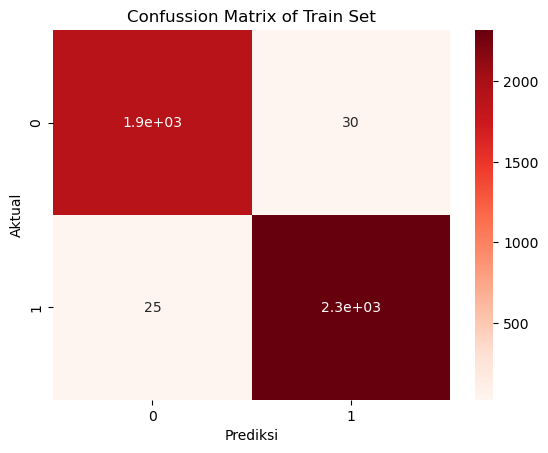

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_train_smoteenn, y_train_pred)

ax = sns.heatmap(cm, annot=True, cmap="Reds")

ax.set_xlabel('Prediksi')
ax.set_ylabel('Aktual')
plt.title('Confussion Matrix of Train Set')
plt.show()

In [115]:
y_pred = cb.predict(test_pool)
print(classification_report(y_test_smoteenn, y_pred))
print(f"accuracy_score test {accuracy_score(y_test_smoteenn, y_pred)}")

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       667
         1.0       0.97      0.97      0.97       756

    accuracy                           0.97      1423
   macro avg       0.97      0.97      0.97      1423
weighted avg       0.97      0.97      0.97      1423

accuracy_score test 0.9655657062543921


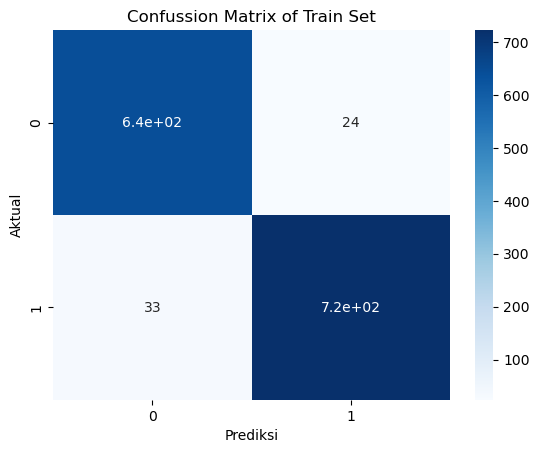

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test_smoteenn, y_pred)

ax = sns.heatmap(cm, annot=True, cmap="Blues")

ax.set_xlabel('Prediksi')
ax.set_ylabel('Aktual')
plt.title('Confussion Matrix of Train Set')
plt.show()

In [117]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(cb, X_test_smoteenn, y_test_smoteenn, cv=5, scoring='f1')
print(f"Cross-validated F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean()}")


0:	learn: 0.5315726	total: 3.54ms	remaining: 704ms
1:	learn: 0.4361879	total: 6.16ms	remaining: 610ms
2:	learn: 0.3605055	total: 8.09ms	remaining: 531ms
3:	learn: 0.3124505	total: 12.1ms	remaining: 591ms
4:	learn: 0.2800995	total: 15ms	remaining: 585ms
5:	learn: 0.2550614	total: 18ms	remaining: 582ms
6:	learn: 0.2347540	total: 20.4ms	remaining: 563ms
7:	learn: 0.2165657	total: 22.1ms	remaining: 531ms
8:	learn: 0.2084279	total: 24.2ms	remaining: 513ms
9:	learn: 0.1974130	total: 26.2ms	remaining: 497ms
10:	learn: 0.1865239	total: 28.3ms	remaining: 486ms
11:	learn: 0.1803312	total: 30.4ms	remaining: 476ms
12:	learn: 0.1706005	total: 32.2ms	remaining: 464ms
13:	learn: 0.1655224	total: 34.1ms	remaining: 453ms
14:	learn: 0.1620415	total: 36.2ms	remaining: 446ms
15:	learn: 0.1553741	total: 38ms	remaining: 436ms
16:	learn: 0.1486313	total: 39.7ms	remaining: 428ms
17:	learn: 0.1429501	total: 41.7ms	remaining: 422ms
18:	learn: 0.1391360	total: 43.6ms	remaining: 415ms
19:	learn: 0.1359927	total: 

# Archived

### Random Forest

In [118]:
# declare model random forest with best parameter from hyperparameter tuning
rf = RandomForestClassifier(n_estimators=100,
                            criterion='entropy',
                            max_features=0.5,
                            min_samples_leaf=10,
                            random_state=11,
                            n_jobs=1)

In [119]:
# fitting the model
rf.fit(X_train_ovs, y_train_ovs)

RandomForestClassifier(criterion='entropy', max_features=0.5,
                       min_samples_leaf=10, n_jobs=1, random_state=11)

In [120]:
# do prediction with data test
rf_pred = rf.predict(X_test_ovs)

In [121]:
# write accuracy score
acc_rf = accuracy_score(y_test_ovs, rf_pred)
acc_rf

0.8470178156467855

### Bagging Classifier

In [122]:
# declare model bagging classifier with best parameter from hyperparameter tuning
bcl = BaggingClassifier(estimator=DTC(criterion='entropy',random_state=11), 
                        n_estimators=100, max_samples=0.9,max_features=0.7, random_state=11, n_jobs=-1)

In [123]:
# fitting the model
bcl.fit(X_train_smoteenn, y_train_smoteenn)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   random_state=11),
                  max_features=0.7, max_samples=0.9, n_estimators=100,
                  n_jobs=-1, random_state=11)

In [124]:
# do prediction with data test
bcl_pred = bcl.predict(X_test_smoteenn)

In [125]:
# write accuracy score
acc_bcl = accuracy_score(y_test_smoteenn, bcl_pred)
acc_bcl

0.9648629655657063

In [126]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train_smoteenn, y_train_smoteenn)

BalancedRandomForestClassifier(random_state=42)

In [127]:
from sklearn.metrics import precision_recall_curve

y_probs = model.predict_proba(X_test_smoteenn)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_smoteenn, y_probs)

In [128]:
from sklearn.metrics import classification_report, f1_score

y_pred = model.predict(X_test_smoteenn)
print(classification_report(y_test_smoteenn, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       667
         1.0       0.97      0.96      0.96       756

    accuracy                           0.96      1423
   macro avg       0.96      0.96      0.96      1423
weighted avg       0.96      0.96      0.96      1423



### Test Using Repeat Stratified K-Fold

In [129]:
def model(classifier):
    classifier.fit(X_train,y_train)
    ml_pred = classifier.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
    print(classification_report(y_test, ml_pred))

### Stacking Classifier

In [130]:
estimators = [
    ('catboost', cb),
    ('random_forest', rf),
    ('bagging', bcl)
]

stack_clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=42))

stack_clf.fit(X_train_ovs, y_train_ovs)

stc_pred = stack_clf.predict(X_test_ovs)

0:	learn: 0.6210920	total: 30.2ms	remaining: 6s
1:	learn: 0.5655592	total: 39.7ms	remaining: 3.93s
2:	learn: 0.5278576	total: 82.9ms	remaining: 5.45s
3:	learn: 0.4977423	total: 86.7ms	remaining: 4.25s
4:	learn: 0.4785802	total: 116ms	remaining: 4.52s
5:	learn: 0.4569382	total: 120ms	remaining: 3.89s
6:	learn: 0.4361673	total: 124ms	remaining: 3.41s
7:	learn: 0.4252699	total: 128ms	remaining: 3.06s
8:	learn: 0.4164523	total: 131ms	remaining: 2.79s
9:	learn: 0.4092623	total: 135ms	remaining: 2.57s
10:	learn: 0.4028620	total: 139ms	remaining: 2.39s
11:	learn: 0.3938775	total: 145ms	remaining: 2.27s
12:	learn: 0.3891539	total: 150ms	remaining: 2.16s
13:	learn: 0.3830113	total: 155ms	remaining: 2.05s
14:	learn: 0.3795906	total: 158ms	remaining: 1.95s
15:	learn: 0.3773922	total: 161ms	remaining: 1.85s
16:	learn: 0.3725535	total: 165ms	remaining: 1.77s
17:	learn: 0.3679819	total: 168ms	remaining: 1.7s
18:	learn: 0.3659243	total: 172ms	remaining: 1.64s
19:	learn: 0.3630136	total: 176ms	remaini

In [131]:
acc_stc = accuracy_score(y_test_ovs, stc_pred)
print(f'accuracy stacked model: {acc_stc}')

accuracy stacked model: 0.8454686289697909


In [ ]:
print(classification_report(y_test_ovs, stc_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84      1264
         1.0       0.86      0.83      0.84      1318

    accuracy                           0.84      2582
   macro avg       0.84      0.84      0.84      2582
weighted avg       0.84      0.84      0.84      2582



### Neural Network

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
124/124 [==============================] - 1s 4ms/step - loss: 37.5735 - accuracy: 0.6307 - val_loss: 14.6229 - val_accuracy: 0.7279
Epoch 2/100
124/124 [==============================] - 0s 3ms/step - loss: 14.9281 - accuracy: 0.6408 - val_loss: 4.9581 - val_accuracy: 0.7574
Epoch 3/100
124/124 [==============================] - 0s 2ms/step - loss: 7.1823 - accuracy: 0.6312 - val_loss: 2.1341 - val_accuracy: 0.7675
Epoch 4/100
124/124 [==============================] - 0s 3ms/step - loss: 4.0557 - accuracy: 0.6495 - val_loss: 0.9848 - val_accuracy: 0.7279
Epoch 5/100
124/124 [==============================] - 0s 2ms/step - loss: 2.6218 - accuracy: 0.6782 - val_loss: 1.0157 - val_accuracy: 0.7279
Epoch 6/100
124/124 [==============================] - 0s 3ms/step - loss: 2.0577 - accuracy: 0.6988 - val_loss: 0.9566 - val_accuracy: 0.7279
Epoch 7/100
124/124 [==============================] - 0s 2ms/step - loss: 1.7800 - accuracy: 0.6919 - val_loss: 0.9428 - val_accuracy: 0.7

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

65/65 [==============================] - 1s 5ms/step - loss: 0.5124 - accuracy: 0.7429
Loss: 0.5124051570892334, Accuracy: 0.742926836013794


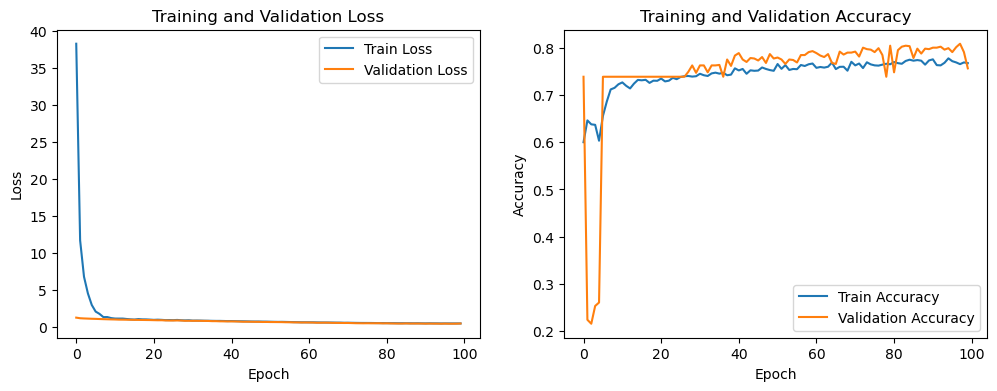

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()